# 5. Final Model - Clean Notebook with Output for API

## Introduction

Final model and the scripts to transfer to API.

## Load libraries

In [35]:
# Set up

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt

import pickle as pkl
import seaborn as sns

import itertools
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

from sklearn.mixture import GaussianMixture

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn import linear_model

import xgboost as xgb

from feature_selector import FeatureSelector

%load_ext autoreload
%autoreload 2
%matplotlib inline

LOCAL_DIR = '/home/jovyan/notebook/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Load data
df = pd.read_csv(LOCAL_DIR + 'brainFitDx/data/sample/sample_2000_for_model.csv')

In [37]:
df.head(5)

,hhidpn,brain_health_1,brain_health_2,brain_health_3,total_cog,total_recall,serial7,tics,backwards_20,immediate_recall,...,g2918,g2940,g2995,g2996,g2999,g3002,g3060,adams,brain_health_diag2,kmeans
0,2010,0,1,1,14.0,8,0,6.0,2,5,...,0,0.0,5,0.0,4.0,1,1.0,NaN,NaN,0
1,3010,0,0,0,24.0,20,4,0.0,2,10,...,0,0.0,1,200.0,2.0,1,2.0,NaN,NaN,0
2,3020,0,0,0,16.0,11,5,0.0,2,6,...,0,0.0,1,10.0,0.0,5,2.0,NaN,NaN,0
3,10001010,0,0,0,19.0,14,5,0.0,2,7,...,0,0.0,5,0.0,130.0,1,4.0,NaN,NaN,0
4,10003030,0,0,0,25.0,20,5,0.0,2,10,...,0,0.0,5,0.0,0.0,5,4.0,NaN,NaN,0


In [41]:
# THESE ARE THE 'FINAL' FEATURES

features2_1 = [
 'total_recall',
 'serial7',
 #'tics', removed
 'backwards_20',
 'immediate_recall',
 'delayed_recall',
 'g1101',
 'g1074a',
 'g1158',
 'g1226',
 'g1240',
 'g1242',
 'g1289',
 'g1290',
 'g1323',
 'g1329',
 'g1340',
 'g1345',
 'g1361',
 'g1363',
 'g1369',
 'g1374',
 'g1395',
 'g1416',
 'g1425',
 'g1442',
 #'g1805',
 #'g1814_05',
 #'g1814', removed 
 'g2707',
 'g2710',
 'g2723',
 'g2725',
 'g2726',
 'g2745',
 'g2755',
 'g2847',
 'g2851',
 'g2860',
 'g2865',
 'g2870',
 'g2915',
 'g2916',
 'g2918',
 'g2940',
 'g3002',
 'g1_trend_health'
]

In [42]:
# Corresponding feature names in web application

new_names = ['23', '25', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '22', '24', 'total_recall'
        ]

## Calculate sample statistics for key inputs (health, cognitive, living)

In [46]:
temp_df = df.loc[:,features2_1]

In [47]:
# compute unweighted benchmarks for health domains

# cognitive health
def cognitive_health(d):
    """
    Args:
    d: df row
    
    Returns:
    percentage 
    
    """
    accuracy=(d['immediate_recall']+d['delayed_recall']+d['backwards_20']+d['serial7'])/27
    return round(accuracy*100, 3)

# physical health
def physical_health(d):
    """
    Args: 
    d: df row
    
    Returns:
    percentage 
    
    """
    # binary questions
    binary_ques=['g1240', 'g1289', 'g1290', 'g1329', 'g1345', 'g1442']
    binary_score=[d[b] for b in binary_ques].count(1)
    if d['g1395']==5:
        binary_score+=1
        
    # numeric questions
    numeric_ques=['g1226', 'g1242', 'g1323', 'g1340', 'g1361', 'g1363', 'g1369', 'g1374', 'g1416', 'g1_trend_health']
    numeric_score=sum([d[n] for n in numeric_ques])
    
    # final score
    final_score=(binary_score+numeric_score)/72
    return (round((1-final_score)*100, 3))

# living health
def living_health(d):
    """
    Args: 
    d: df row 
    
    Returns:
    percentage
    
    """
    score=0
    
    # binary questions
    binary_ques=['g2707', 'g2710', 'g2723', 'g2725', 'g2726', 'g2745', 'g2755', 'g2847', 'g2851', 'g2860', 
                 'g2865', 'g2870', 'g2915', 'g2916', 'g2918']
    score+=[d[b] for b in binary_ques].count(1)
    
    # numeric questions
    if d['g2940']>=1:
        score+=1
    if d['g3002']!=1:
        score+=1
        
    # final score
    final_score=score/17
    return round((1-final_score)*100, 3)


In [48]:
# create columns
temp_df['cognitive_health']=temp_df.apply(cognitive_health, axis=1)
temp_df['physical_health']=temp_df.apply(physical_health, axis=1)
temp_df['living_health']=temp_df.apply(living_health, axis=1)

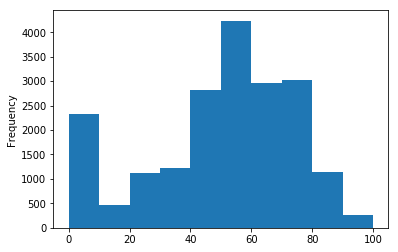

In [49]:
temp_df['cognitive_health'].plot.hist()

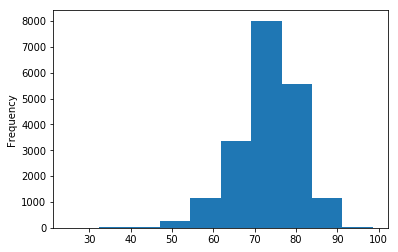

In [50]:
temp_df['physical_health'].plot.hist()

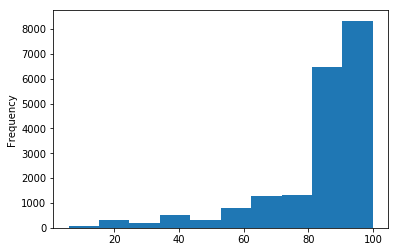

In [51]:
temp_df['living_health'].plot.hist()

In [52]:
temp_df = temp_df.loc[:,['g1101', 'physical_health', 'cognitive_health', 'living_health']]

In [53]:
temp_df2 = temp_df.sort_values('g1101')
bins = [0, 50, 60, 70, 80, 90, 100, 120]
temp_df2['group'] = np.digitize(temp_df2['g1101'],bins)
grouped = temp_df2.groupby('group')

In [54]:
for test in ['cognitive_health', 'physical_health', 'living_health']:
    print( grouped[test].describe())

        count       mean        std  min     25%     50%     75%      max
group                                                                    
1       574.0  58.536594  23.840681  0.0  51.852  62.963  74.074  100.000
2      4645.0  57.982686  22.155720  0.0  48.148  62.963  74.074  100.000
3      6860.0  53.448322  23.340632  0.0  44.444  59.259  70.370  100.000
4      4639.0  46.427636  22.859118  0.0  33.333  51.852  62.963  100.000
5      2437.0  35.008135  23.443938  0.0  14.815  37.037  51.852  100.000
6       408.0  20.715333  20.317948  0.0   0.000  18.519  37.037   74.074
7        16.0   3.009313   8.025980  0.0   0.000   0.000   0.000   29.630
        count       mean       std     min     25%      50%     75%     max
group                                                                      
1       574.0  77.211573  7.164817  51.389  73.611  77.7780  81.944  91.667
2      4645.0  75.762165  6.970710  47.222  70.833  76.3890  80.556  98.611
3      6860.0  73.862977  7.29

In [55]:
for test in ['cognitive_health', 'physical_health', 'living_health']:
    grouped[test].describe().to_csv(str(test)+'.csv')

## Final Model

In [67]:
# Features
features2_1.sort()
print(features2_1)
print(len(features2_1))

['backwards_20', 'delayed_recall', 'g1074a', 'g1101', 'g1158', 'g1226', 'g1240', 'g1242', 'g1289', 'g1290', 'g1323', 'g1329', 'g1340', 'g1345', 'g1361', 'g1363', 'g1369', 'g1374', 'g1395', 'g1416', 'g1425', 'g1442', 'g1_trend_health', 'g2707', 'g2710', 'g2723', 'g2725', 'g2726', 'g2745', 'g2755', 'g2847', 'g2851', 'g2860', 'g2865', 'g2870', 'g2915', 'g2916', 'g2918', 'g2940', 'g3002', 'immediate_recall', 'serial7', 'total_recall']
43


In [68]:
X = df.loc[:,features2_1]
y = df['kmeans']

In [69]:
X.rename(columns=dict(zip(features2_1, new_names)), inplace=True)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = pd.DataFrame(data=X_train, columns=new_names)
X_test = pd.DataFrame(data=X_test, columns=new_names)


Classification report: 
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1463
          1       0.97      0.94      0.96       495

avg / total       0.98      0.98      0.98      1958



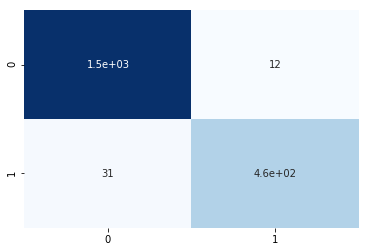

In [71]:
# Estimate and examine model
clf = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, min_child_weight=1, max_depth=3, learning_rate=0.3, seed=42)
model = clf.fit(X_train,y_train)
y_pred = model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(confusion), annot=True, cbar=None, cmap='Blues')
print ('Classification report: \n{}'.format(classification_report(y_test, y_pred)))


## Saving Model

In [101]:
X = df.loc[:,features2_1]
y = df['kmeans']

In [102]:
X.rename(columns=dict(zip(features2_1, new_names)), inplace=True)
X.head(2)

,23,25,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,22,24,total_recall
0,2,3,8,65,2,3,0,0,5,0,...,5,5,1,5,0,0.0,1,5,0,8
1,2,10,12,64,1,4,0,0,1,1,...,5,5,5,5,0,0.0,1,10,4,20


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = pd.DataFrame(data=X_train, columns=new_names)
X_test = pd.DataFrame(data=X_test, columns=new_names)

In [104]:
# Save the model
train_data = xgb.DMatrix(X_train, y_train)
param = {'max_depth':3, 'eta':0.3, 'silent':1, 'gamma':0.5, 'min_child_weight':1, 'seed':42, 'objective':'binary:logistic'}
num_round = 100
model = xgb.train(param, train_data, num_round)

pkl.dump(model, open('xgb_model.pkl','wb'), protocol=2)

In [105]:
# Load model
xgb_model = pkl.load(open('xgb_model.pkl','rb'))

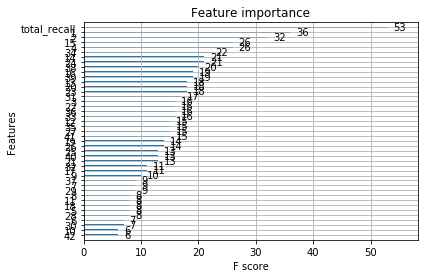

In [106]:
xgb.plot_importance(xgb_model)

In [107]:
# Save to file test data
X_test2 = X_test.iloc[1:2,:]
#X_test.to_csv('testinput.csv', index=False)
X_test2.to_json('testinput.json',orient='records')

In [108]:
X_test2

,23,25,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,22,24,total_recall
4881,2,3,10,60,1,3,0,0,5,0,...,5,5,1,5,0,0.0,1,4,3,7


In [80]:
with open('testinput.json') as json_file:  
    json_df = json.load(json_file)

In [81]:
json.dumps(json_df)

'[{"23": 2, "25": 3, "1": 10, "2": 60, "3": 1, "4": 3, "5": 0, "6": 0, "7": 5, "8": 0, "9": 0, "10": 5, "11": 0.0, "12": 0, "13": 3, "14": 3, "15": 2, "16": 0, "17": 5, "18": 0.0, "19": 180, "20": 5, "21": 0, "26": 5, "27": 5, "28": 5, "29": 5, "30": 5, "31": 0, "32": 0, "33": 0, "34": 5, "35": 1, "36": 5, "37": 5, "38": 1, "39": 5, "40": 0, "41": 0.0, "42": 1, "22": 4, "24": 3, "total_recall": 7}]'

In [82]:
load_df2 = pd.DataFrame(json_df)

In [83]:
load_df2

,1,10,11,12,13,14,15,16,17,18,...,4,40,41,42,5,6,7,8,9,total_recall
0,10,5,0.0,0,3,3,2,0,5,0.0,...,3,0,0.0,1,0,0,5,0,0,7


In [84]:
load_df = pd.read_json('testinput.json')
load_dfc = pd.read_csv('cognitive_health.csv')
load_dfp = pd.read_csv('physical_health.csv')
load_dfl = pd.read_csv('living_health.csv')

In [85]:
load_dfc

,group,count,mean,std,min,25%,50%,75%,max
0,1,574.0,58.536594,23.840681,0.0,51.852,62.963,74.074,100.000
1,2,4645.0,57.982686,22.155720,0.0,48.148,62.963,74.074,100.000
2,3,6860.0,53.448322,23.340632,0.0,44.444,59.259,70.370,100.000
3,4,4639.0,46.427636,22.859118,0.0,33.333,51.852,62.963,100.000
4,5,2437.0,35.008135,23.443938,0.0,14.815,37.037,51.852,100.000
5,6,408.0,20.715333,20.317948,0.0,0.000,18.519,37.037,74.074
6,7,16.0,3.009313,8.025980,0.0,0.000,0.000,0.000,29.630


In [86]:
load_df = load_df2.loc[:,new_names]

In [87]:
temp = load_df.columns.tolist()
temp_df = pd.DataFrame(temp)
temp_df.to_csv('finalfeatures.csv', header=False, index=False)

In [88]:
load_df.head(4)

,23,25,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,22,24,total_recall
0,2,3,10,60,1,3,0,0,5,0,...,5,5,1,5,0,0.0,1,4,3,7


In [92]:
# Do prediction
load_data_matrix = xgb.DMatrix(load_df)

In [97]:
# Predict
preds = xgb_model.predict(load_data_matrix)
print(preds)

[ 0.02390789]


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


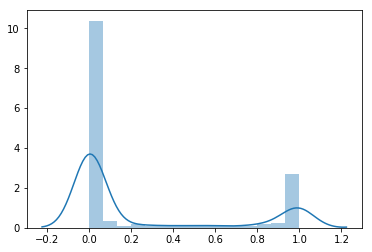

In [109]:
preds = xgb_model.predict(xgb.DMatrix(X_test))
sns.distplot(preds)

In [95]:
%%writefile xgb_model.py
# Program to load model and predict class
# Input: xgb_model.py %1 where %1 is a csv file of features
# Output: array of predictions

import os
import sys
import xgboost as xgb
import pandas as pd
import json
import pickle as pkl

# Load model
xgb_model = pkl.load(open('xgb_model.pkl','rb'))

# Read csv file
inputcvs = pd.read_json(str(sys.argv[1]))

json_2_df = inputcvs.loc[:,['23', '25', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '22', '24', 'total_recall'
        ]]
                       
# Process data
load_data_matrix = xgb.DMatrix(json_2_df)
print(xgb_model.predict(load_data_matrix))                       
                       
                                     

Overwriting xgb_model.py


In [96]:
!python xgb_model.py testinput.json

[ 0.02390789]


In [ ]:
pred

## To write the model.py 

In [110]:
xgb_model = pkl.load(open('xgb_model.pkl','rb'))

In [113]:
data_json = pd.read_json('testinput.json')

In [114]:
data = {"1":17,"2":70,"3":1,"4":1,"5":5,"6":3,"7":5,"8":5,"9":3,"10":5,"11":0,"12":5,"13":2,"14":2,"15":2,"16":3,"17":1,"18":3,"19":180,"20":5,"21":1,"22":[10,6],"23":1,"ts1":1532850133053,"24":[46,39,32,25,18],"ts2":1532850156469,"25":[10,6],"26":1,"27":5,"28":7,"29":6,"30":1,"31":5,"32":1,"33":1,"34":5,"35":5,"36":5,"37":1,"38":5,"39":5,"40":5,"41":1,"42":1}

In [115]:
data['22'] = data['22'][0]
data['25'] = data['25'][0]

In [116]:
temp = 0
for i in range(5):
    if data['24'][i] == (100-47-7-i*7):
        temp += 1

data['24'] = temp

In [117]:
data['total_recall'] = data['22'] + data['25']

In [120]:
data

{'1': 17,
 '2': 70,
 '3': 1,
 '4': 1,
 '5': 5,
 '6': 3,
 '7': 5,
 '8': 5,
 '9': 3,
 '10': 5,
 '11': 0,
 '12': 5,
 '13': 2,
 '14': 2,
 '15': 2,
 '16': 3,
 '17': 1,
 '18': 3,
 '19': 180,
 '20': 5,
 '21': 1,
 '22': 10,
 '23': 1,
 'ts1': 1532850133053,
 '24': 5,
 'ts2': 1532850156469,
 '25': 10,
 '26': 1,
 '27': 5,
 '28': 7,
 '29': 6,
 '30': 1,
 '31': 5,
 '32': 1,
 '33': 1,
 '34': 5,
 '35': 5,
 '36': 5,
 '37': 1,
 '38': 5,
 '39': 5,
 '40': 5,
 '41': 1,
 '42': 1,
 'total_recall': 20}

In [125]:
data_json.values

array([[ 10,   5,   0,   0,   3,   3,   2,   0,   5,   0, 180,  60,   5,
          0,   4,   2,   3,   3,   5,   5,   5,   5,   1,   5,   0,   0,
          0,   5,   1,   5,   5,   1,   5,   3,   0,   0,   1,   0,   0,
          5,   0,   0,   7]])

In [126]:
# compute user performance metrics

# cognitive health 
def compute_cog(d):
    """
    Args: 
    d: dict
    
    Returns:
    percentage
    
    """
    accuracy=(d['22']+d['25']+d['23']+d['24'])/27
    return round(accuracy*100, 3)

# physical health
def compute_physical(d):
    """
    Args: 
    d: dic
    
    Returns:
    percentage 
    
    """
    # binary questions
    binary_ques=[5, 7, 8, 10, 12, 20]
    binary_score=[d[str(b)] for b in binary_ques].count(1)
    if d['17']==5:
        binary_score+=1
        
    # numeric questions
    numeric_ques=[4, 6, 9, 11, 13, 14, 15, 16, 18, 21]
    numeric_score=sum([d[str(n)] for n in numeric_ques])
    
    # final score
    final_score=(binary_score+numeric_score)/72
    return (round((1-final_score)*100, 3))

# living health
def compute_living(d):
    """
    Args: 
    d: dict
    
    Returns:
    percentage
    
    """
    score=0
    score+=[d[str(k)] for k in range(26,41)].count(1)
    if d['41']>=1:
        score+=1
    if d['42']!=1:
        score+=1
    final_score=score/17
    return round((1-final_score)*100, 3)


In [127]:
cog_score = compute_cog(data)
phy_score = compute_physical(data)
liv_score = compute_living(data)

In [140]:
load_df = pd.DataFrame(data, index=[0])
load_df = pd.read_json('testinput.json')

In [141]:
json_2_df = load_df.loc[:,['23', '25', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '22', '24', 'total_recall'
        ]]

In [142]:
json_2_df

,23,25,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,22,24,total_recall
0,2,3,10,60,1,3,0,0,5,0,...,5,5,1,5,0,0,1,4,3,7


In [143]:
json_2_df

,23,25,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,22,24,total_recall
0,2,3,10,60,1,3,0,0,5,0,...,5,5,1,5,0,0,1,4,3,7


In [144]:
load_data_matrix = xgb.DMatrix(json_2_df)

In [145]:
res = xgb_model.predict(load_data_matrix)
print(res)

[ 0.02390789]


In [146]:
lw2009 = json_2_df['total_recall'][0] + json_2_df['23'][0] + json_2_df['24'][0]
if lw2009 > 12:
    lw = 0
else:
    lw = 1

In [147]:
# Access info for scores

i = 0
if json_2_df['2'][0] < 50:
    i = 1
elif json_2_df['2'][0] >= 50 and json_2_df['2'][0] < 60:
    i = 2
elif json_2_df['2'][0] >= 60 and json_2_df['2'][0] < 70:
    i = 3
elif json_2_df['2'][0] >= 70 and json_2_df['2'][0] < 80:
    i = 4
elif json_2_df['2'][0] >= 80 and json_2_df['2'][0] < 90:
    i = 5
elif json_2_df['2'][0] >= 90 and json_2_df['2'][0] < 100:
    i = 6
else:
    i = 7


In [148]:
# Given an age group

cogs = load_dfc.loc[load_dfc['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
cogs.append(cog_score)

phys = load_dfp.loc[load_dfp['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
phys.append(phy_score)

livs = load_dfl.loc[load_dfl['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
livs.append(liv_score)

In [149]:
# Variables to pass
results = {}
results['Predicted'] = res[0]
results['LW2009'] = lw2009
results['LWClass'] = lw
results['Cog'] = cogs
results['Phys'] = phys
results['Livs'] = livs
print (results)

{'Predicted': 0.023907889, 'LW2009': 12, 'LWClass': 1, 'Cog': [53.44832186588921, 44.443999999999996, 59.25899999999999, 70.37, 100.0, 96.296], 'Phys': [73.86297682215744, 69.444, 75.0, 79.167, 91.667, 72.222], 'Livs': [86.83251428571428, 82.353, 88.235, 94.118, 100.0, 64.706]}


In [150]:
%%writefile model.py

import os
import sys
import xgboost as xgb
import pandas as pd
import numpy as np
import json
import pickle as pkl

# Load model
xgb_model = pkl.load(open('xgb_model.pkl','rb'))

# Load distribution
load_dfc = pd.read_csv('cognitive_health.csv')
load_dfp = pd.read_csv('physical_health.csv')
load_dfl = pd.read_csv('living_health.csv')

# cognitive health 
def compute_cog(d):
    """
    Args: 
    d: dict
    
    Returns:
    percentage
    
    """
    accuracy=(d['22']+d['25']+d['23']+d['24'])/27
    return round(accuracy*100, 3)

# physical health
def compute_physical(d):
    """
    Args: 
    d: dic
    
    Returns:
    percentage 
    
    """
    # binary questions
    binary_ques=[5, 7, 8, 10, 12, 20]
    binary_score=[d[str(b)] for b in binary_ques].count(1)
    if d['17']==5:
        binary_score+=1
        
    # numeric questions
    numeric_ques=[4, 6, 9, 11, 13, 14, 15, 16, 18, 21]
    numeric_score=sum([d[str(n)] for n in numeric_ques])
    
    # final score
    final_score=(binary_score+numeric_score)/72
    return (round((1-final_score)*100, 3))

# living health
def compute_living(d):
    """
    Args: 
    d: dict
    
    Returns:
    percentage
    
    """
    score=0
    score+=[d[str(k)] for k in range(26,41)].count(1)
    if d['41']>=1:
        score+=1
    if d['42']!=1:
        score+=1
    final_score=score/17
    return round((1-final_score)*100, 3)


def api_predict(data):

    # Transform data
    data['22'] = data['22'][0] 
    data['25'] = data['25'][0] 
    temp = 0
    for i in range(5):
        if data['24'][i] == (100-47-7-i*7):
            temp += 1
    data['24'] = temp
    data['total_recall'] = data['22'] + data['25']
    
    # Calculate scores
    cog_score = compute_cog(data)
    phy_score = compute_physical(data)
    liv_score = compute_living(data)
  
    # Create panda
    load_df = pd.DataFrame(data, index=[0])
    #load_df = pd.read_json(inputfile)

    
    # Make sure order is consistent with training
    json_2_df = load_df.loc[:,['23', '25', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '22', '24', 'total_recall'
        ]]
    
    # Load data
    load_data_matrix = xgb.DMatrix(json_2_df)
    
    # Run prediction
    res = xgb_model.predict(load_data_matrix)
    
    # Calculate LW2009 score
    lw2009 = json_2_df['total_recall'][0] + json_2_df['23'][0] + json_2_df['24'][0]
    if lw2009 > 12:
        lw = 0
    else:
        lw = 1
      
    #print ('Internal info:')
    #print (data)
    #print (res, lw2009, lw)
    
    # Add in scores
    
    # Access info for scores
    i = 0
    if json_2_df['2'][0] < 50:
        i = 1
    elif json_2_df['2'][0] >= 50 and json_2_df['2'][0] < 60:
        i = 2
    elif json_2_df['2'][0] >= 60 and json_2_df['2'][0] < 70:
        i = 3
    elif json_2_df['2'][0] >= 70 and json_2_df['2'][0] < 80:
        i = 4
    elif json_2_df['2'][0] >= 80 and json_2_df['2'][0] < 90:
        i = 5
    elif json_2_df['2'][0] >= 90 and json_2_df['2'][0] < 100:
        i = 6
    else:
        i = 7
        
    # Given an age group

    cogs = load_dfc.loc[load_dfc['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
    cogs.append(cog_score)

    phys = load_dfp.loc[load_dfp['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
    phys.append(phy_score)

    livs = load_dfl.loc[load_dfl['group']==i, ['mean', '25%', '50%', '75%',  'max',]].values.tolist()[0]
    livs.append(liv_score)

    # Calculate Predicted Class, using a 0.5 hurdle - may need to change

    if res[0] > 0.5:
        pred_class = 1
    else:
        pred_class = 0

    # Calculate the Aggregate Dementia Risk Score:
    # Score = 1 if mixed results
    agg_score = 1
    # Score = 2 if both dementia class
    if pred_class == 1 & lw == 1:
        agg_score = 2
    # Score = 0 if both normal class
    if pred_class ==0 & lw == 0:
        agg_score = 0

    #print(agg_score,cog_score, cogs[2], phy_score, phys[2], liv_score, livs[2])

    pref_str = ','.join(map(str,[agg_score, cog_score, cogs[0], phy_score, phys[0], liv_score, livs[0]]))

    original_str = '{ "Predicted": ' + str(res[0]) + ', "LW2009": ' + str(lw2009) + ', "LWClass": ' + str(lw) + ', "Cog": ' + str(cogs) + ', "Phys": ' + str(phys) + ', "Livs": ' + str(livs) + '}'

    return pref_str

Overwriting model.py


In [151]:
import model

In [152]:
model.api_predict({"1":17,"2":70,"3":5,"4":1,"5":1,"6":1,"7":1,"8":1,"9":3,"10":1,"11":1,"12":1,"13":2,"14":2,"15":2,"16":3,"17":1,"18":3,"19":120,"20":5,"21":1,"22":[10,6],"23":1,"ts1":1532850133053,"24":[46,39,32,25,18],"ts2":1532850156469,"25":[10,6],"26":1,"27":5,"28":7,"29":6,"30":1,"31":5,"32":1,"33":5,"34":5,"35":1,"36":5,"37":1,"38":5,"39":5,"40":1,"41":1,"42":1})

'1,96.296,46.42763634403966,66.667,72.34078400517353,58.824,80.62593123517999'